In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import pandas as pd

from kan import create_dataset, KAN, KANLayer
from kan.MLP import MLP

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import shap


from source import plot_f_2d, plot_f_3d, scatter_prediction_kan, kan_summary_after_fit
from source import lmdKANLayer, lmdKAN, importance_analyse_lmdKAN


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

c:\Users\Gavriil\VS_projects\lambda_KAN\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


-----
-----
## $f_2(x_1, x_2, x_3, x_4)$

##### $f_2(x_1, x_2, x_3, x_4) = \sin(\pi \cdot (x_1 \cdot x_2 + \tanh(x_1^2+x_2^2)))$

c:\Users\Gavriil\VS_projects\lambda_KAN\.venv\lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


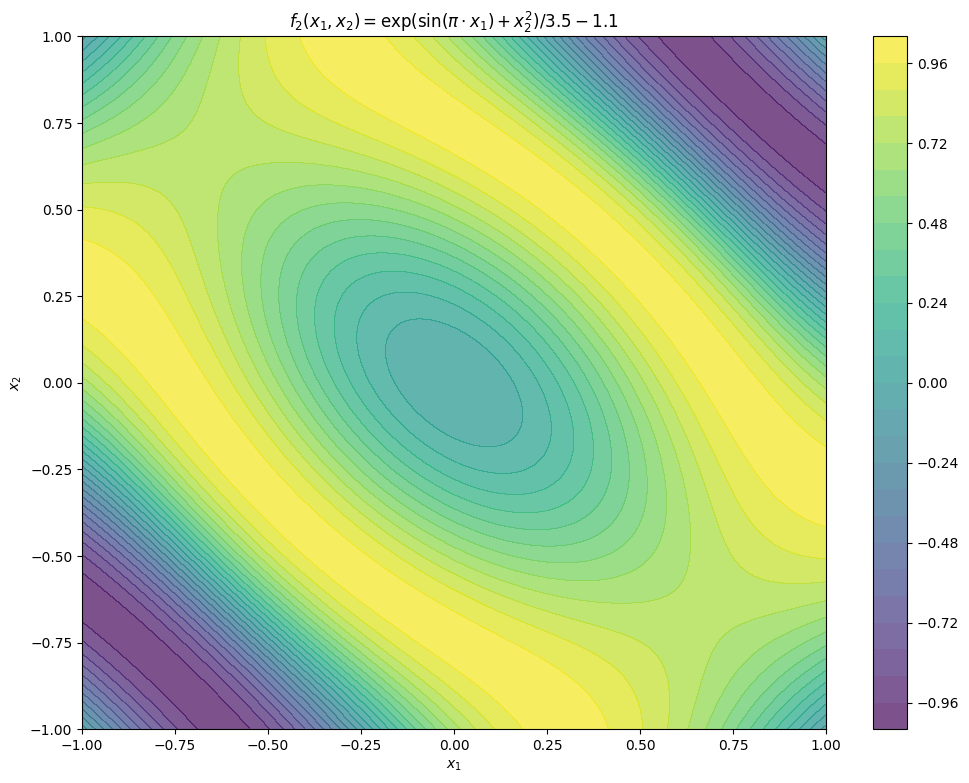

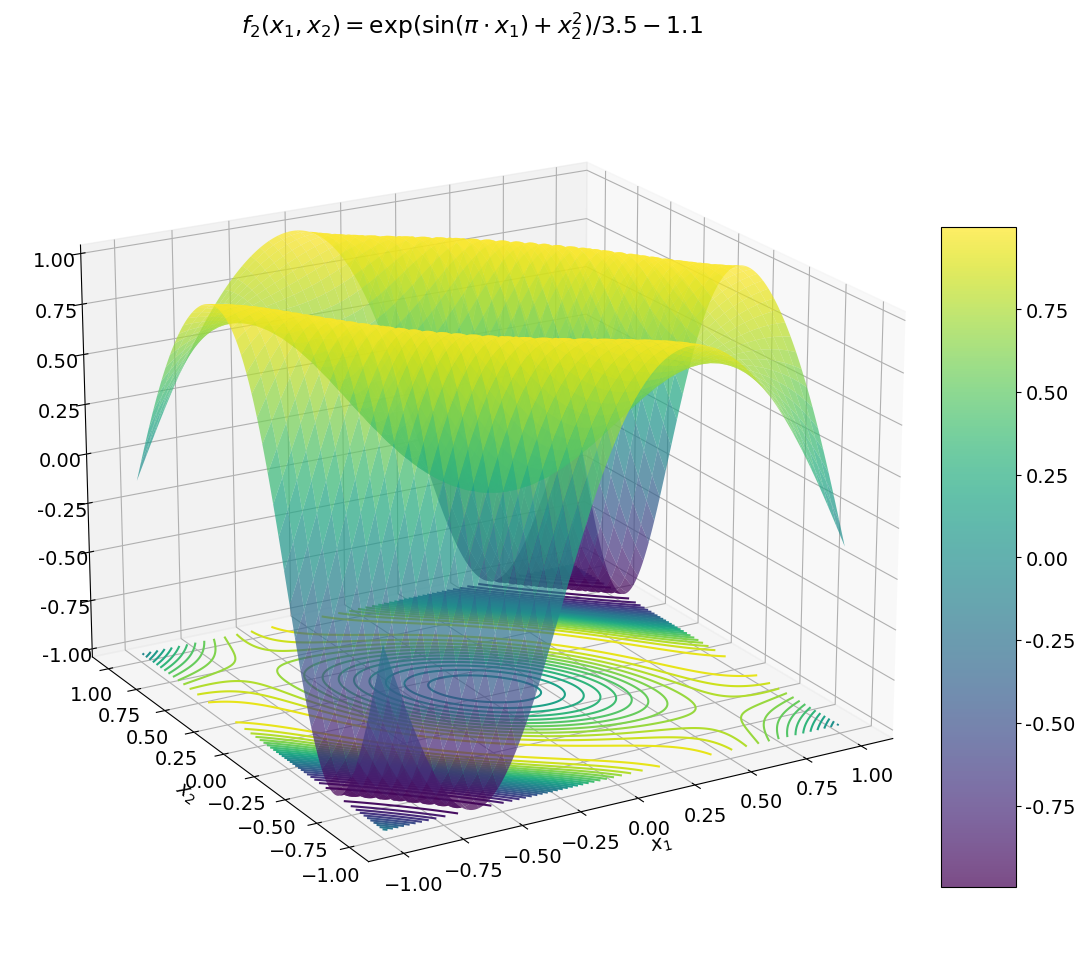

In [2]:
# create dataset
f2 = lambda x: torch.sin(torch.pi*( (x[:,[0]]*x[:,[1]]) + torch.tanh(x[:,[0]]**2 + x[:,[1]]**2) ))
dataset2 = create_dataset(f2, n_var=4, device=device)

f = f2
dataset = dataset2

plot_f_2d(f2, title='$f_2(x_1, x_2) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$')
plot_f_3d(f2, title='$f_2(x_1, x_2) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$')

-----
### MLP on $f_2$

№ model trainable params: 246


description:   0%|                                                          | 0/100 [00:00<?, ?it/s]

| train_loss: 2.61e-02 | test_loss: 2.76e-02 | reg: 1.23e+02 | : 100%|█| 100/100 [00:28<00:00,  3.57


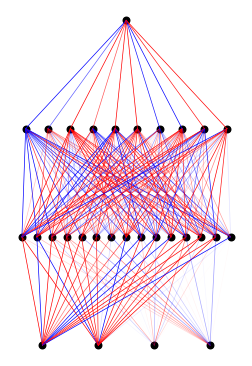

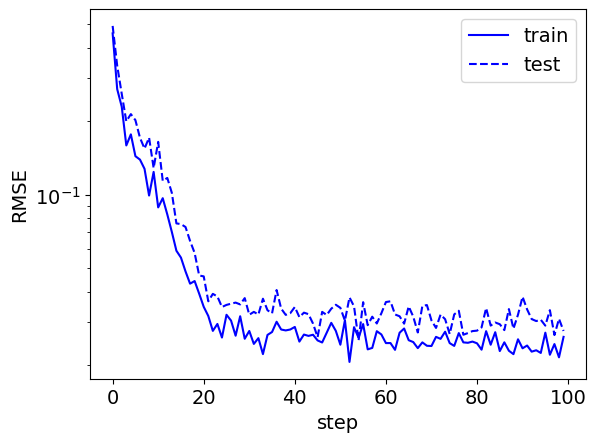

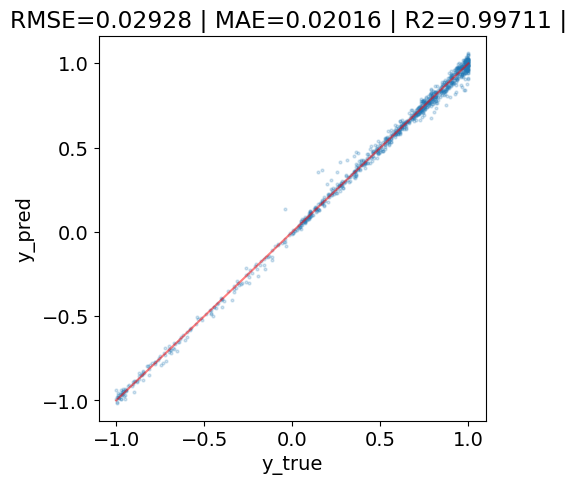

In [4]:
# initialize MLP
model = MLP(width=[4,15,10,1], seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb = 0, batch=250)
kan_summary_after_fit(model, dataset, results)

-----
### KAN on $f_2$

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 300


description:   0%|                                                          | 0/100 [00:00<?, ?it/s]

| train_loss: 9.14e-03 | test_loss: 9.70e-03 | reg: 1.06e+01 | : 100%|█| 100/100 [03:18<00:00,  1.98


saving model version 0.1


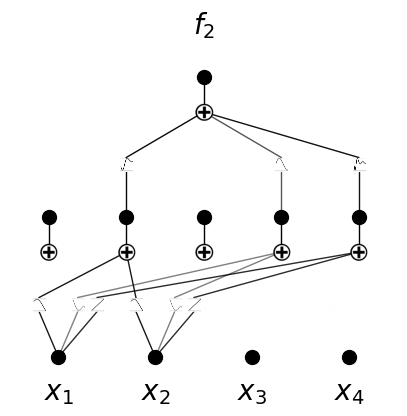

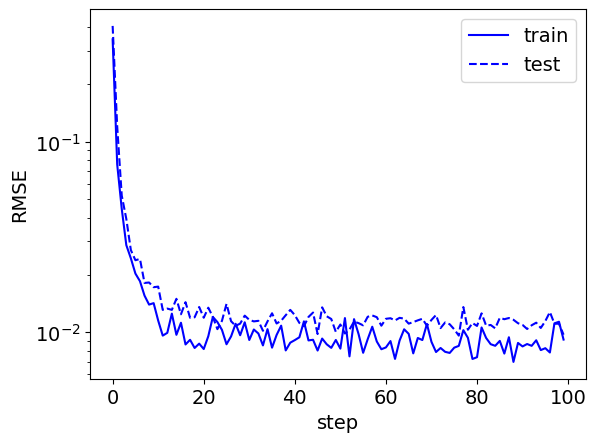

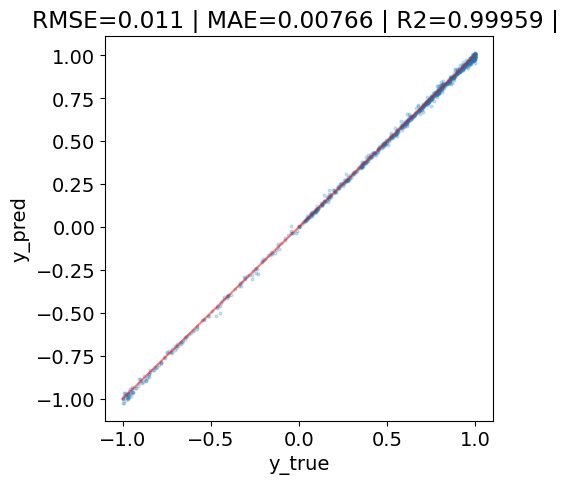

In [5]:
# initialize KAN with G=3
model = KAN(width=[4,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb=1e-4, update_grid=False, batch=250)
kan_summary_after_fit(model, dataset, results, in_vars = ['$x_1$', '$x_2$', '$x_3$', '$x_4$'], out_vars = ['$f_2$'])

-----
### $\lambda$-KAN on $f_2$

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 184


description:   0%|                                                          | 0/150 [00:00<?, ?it/s]

| train_loss: 2.12e-02 | test_loss: 3.18e-02 | reg: 1.63e+01 | : 100%|█| 150/150 [04:35<00:00,  1.83


saving model version 0.1


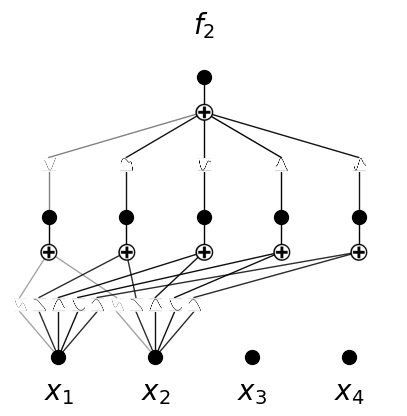

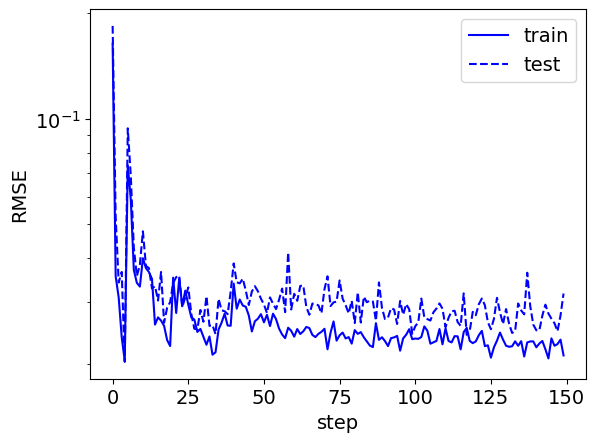

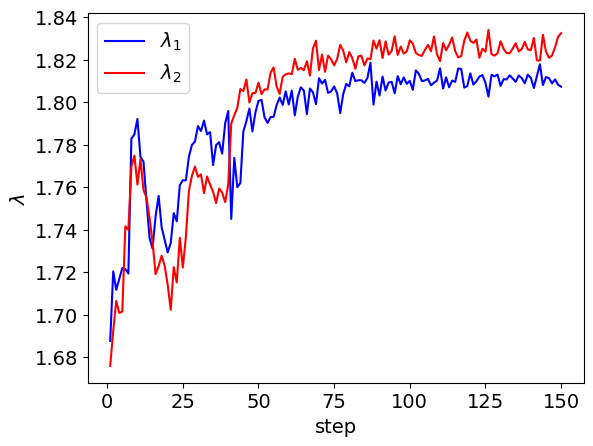

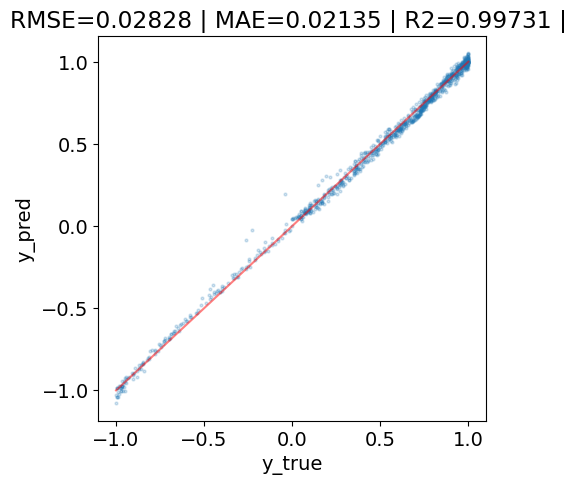

model.act_fun[0].lmd=Parameter containing:
tensor([ 1.8072e+00,  1.8324e+00,  4.2535e-03, -1.2601e-03],
       requires_grad=True)


In [6]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[4,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=0.0, reg_type='entropy',
                    batch=250)
kan_summary_after_fit(model, dataset, results, lmdKAN=True, in_vars = ['$x_1$', '$x_2$', '$x_3$', '$x_4$'], out_vars = ['$f_2$'])
print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [13:23,  1.25it/s]                         


module of Input importance:


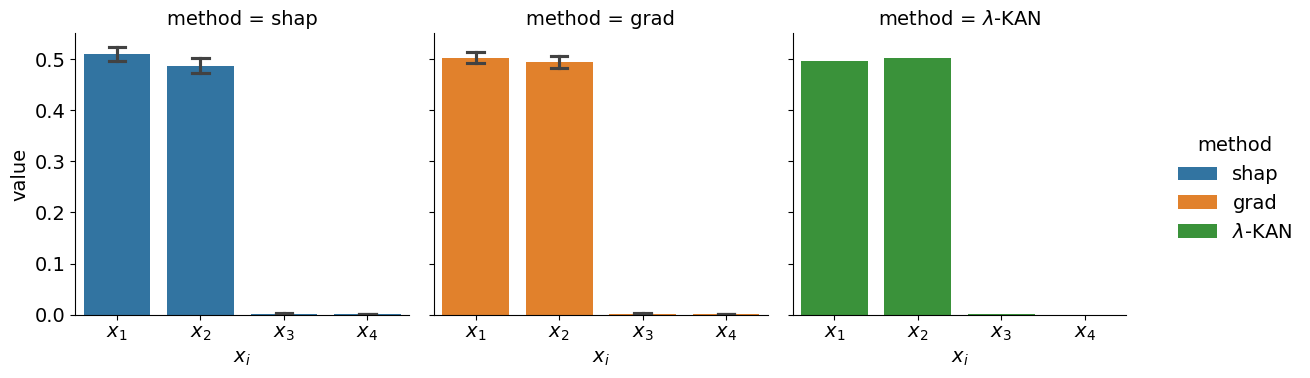

Input importance:


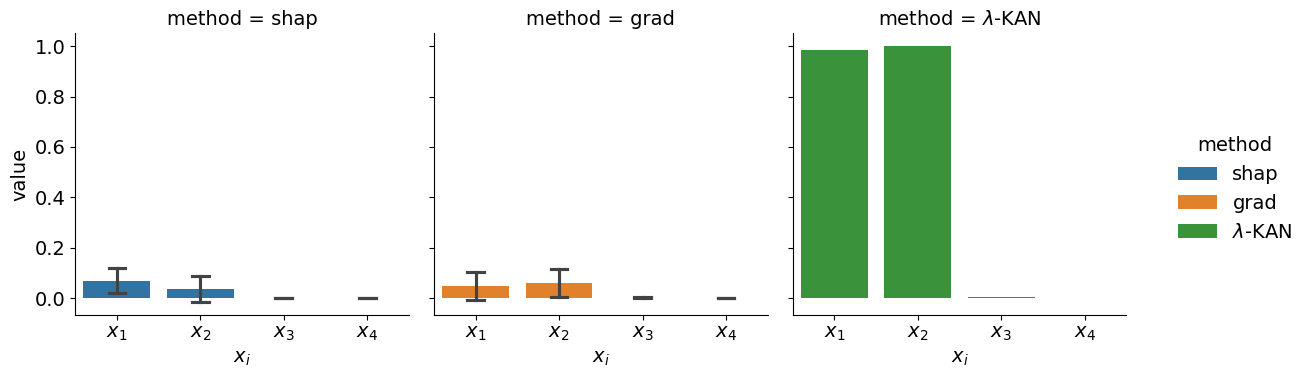

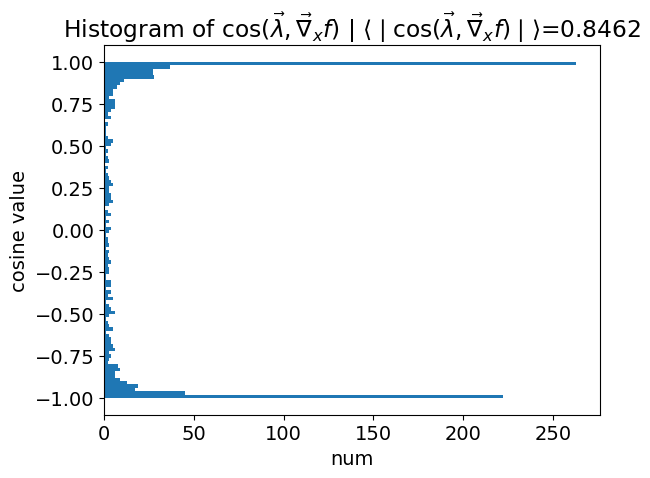

In [7]:
importance_analyse_lmdKAN(model, dataset)

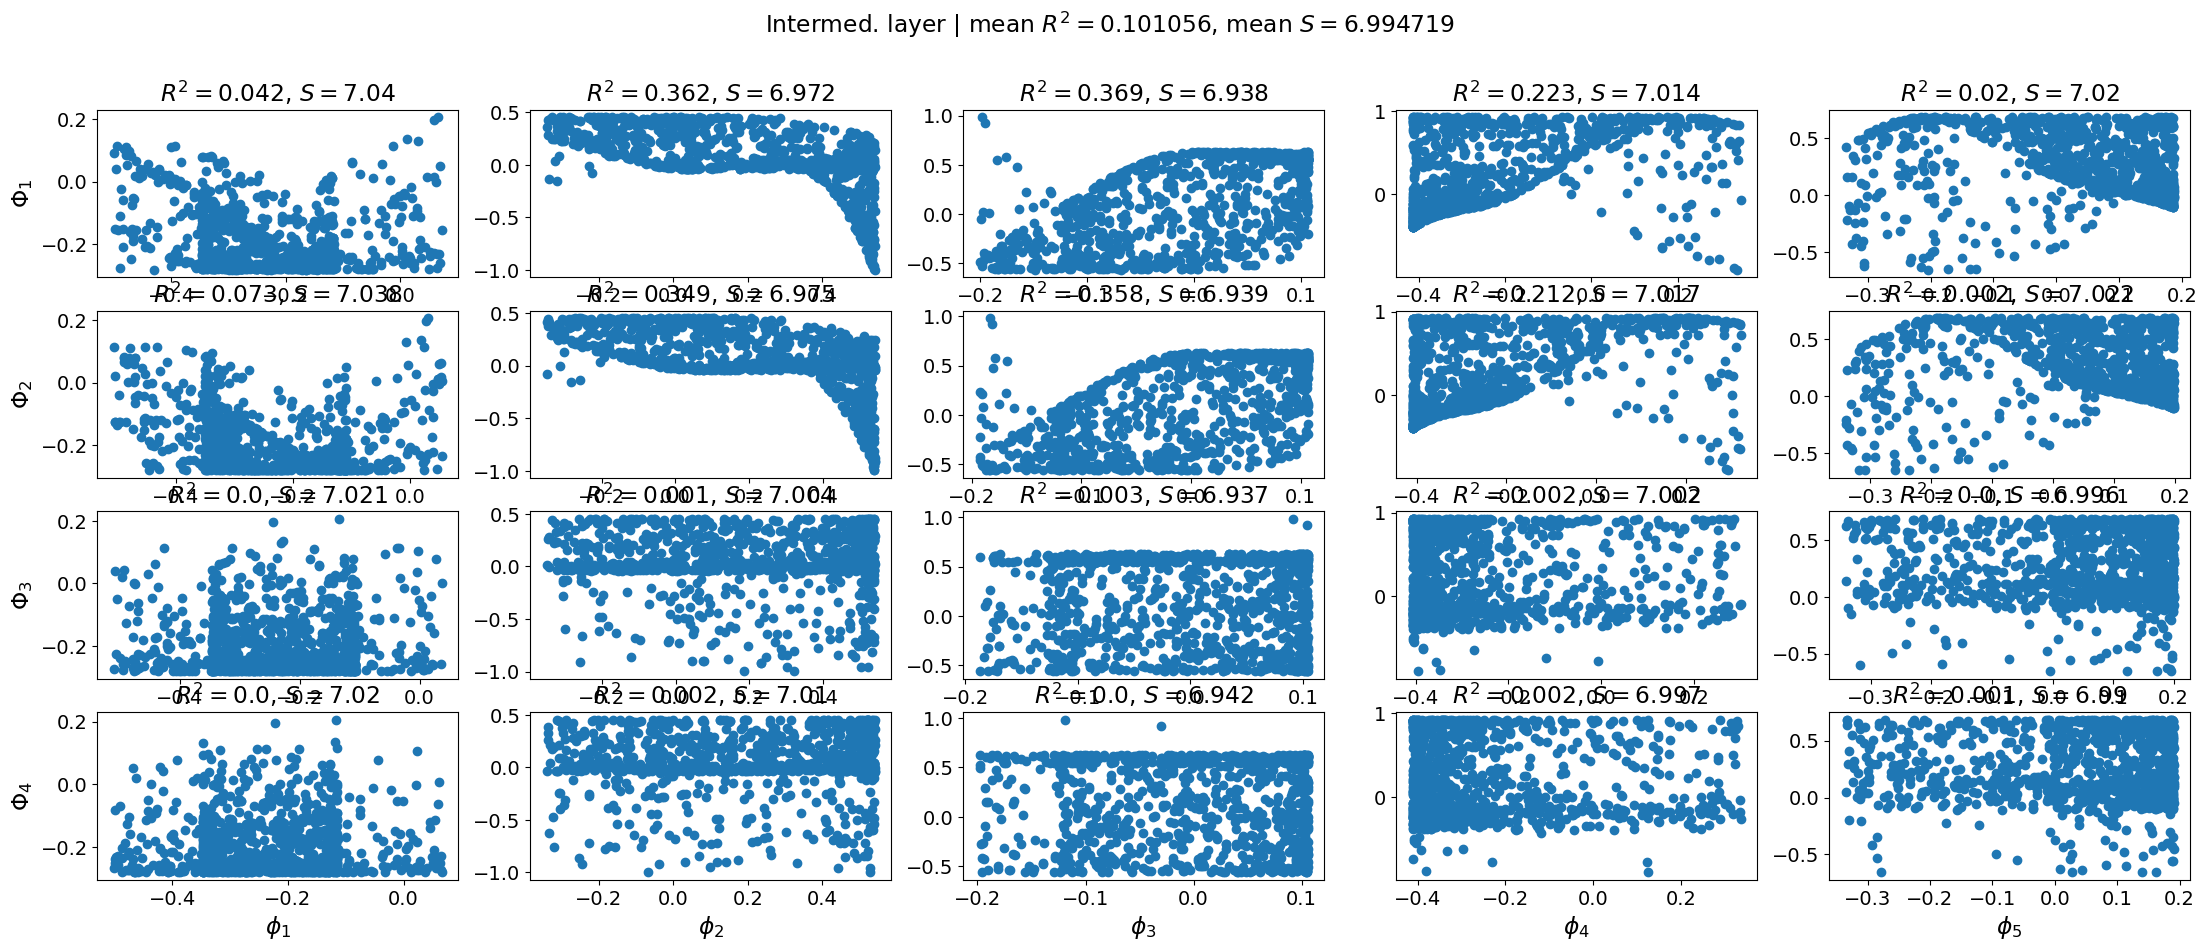

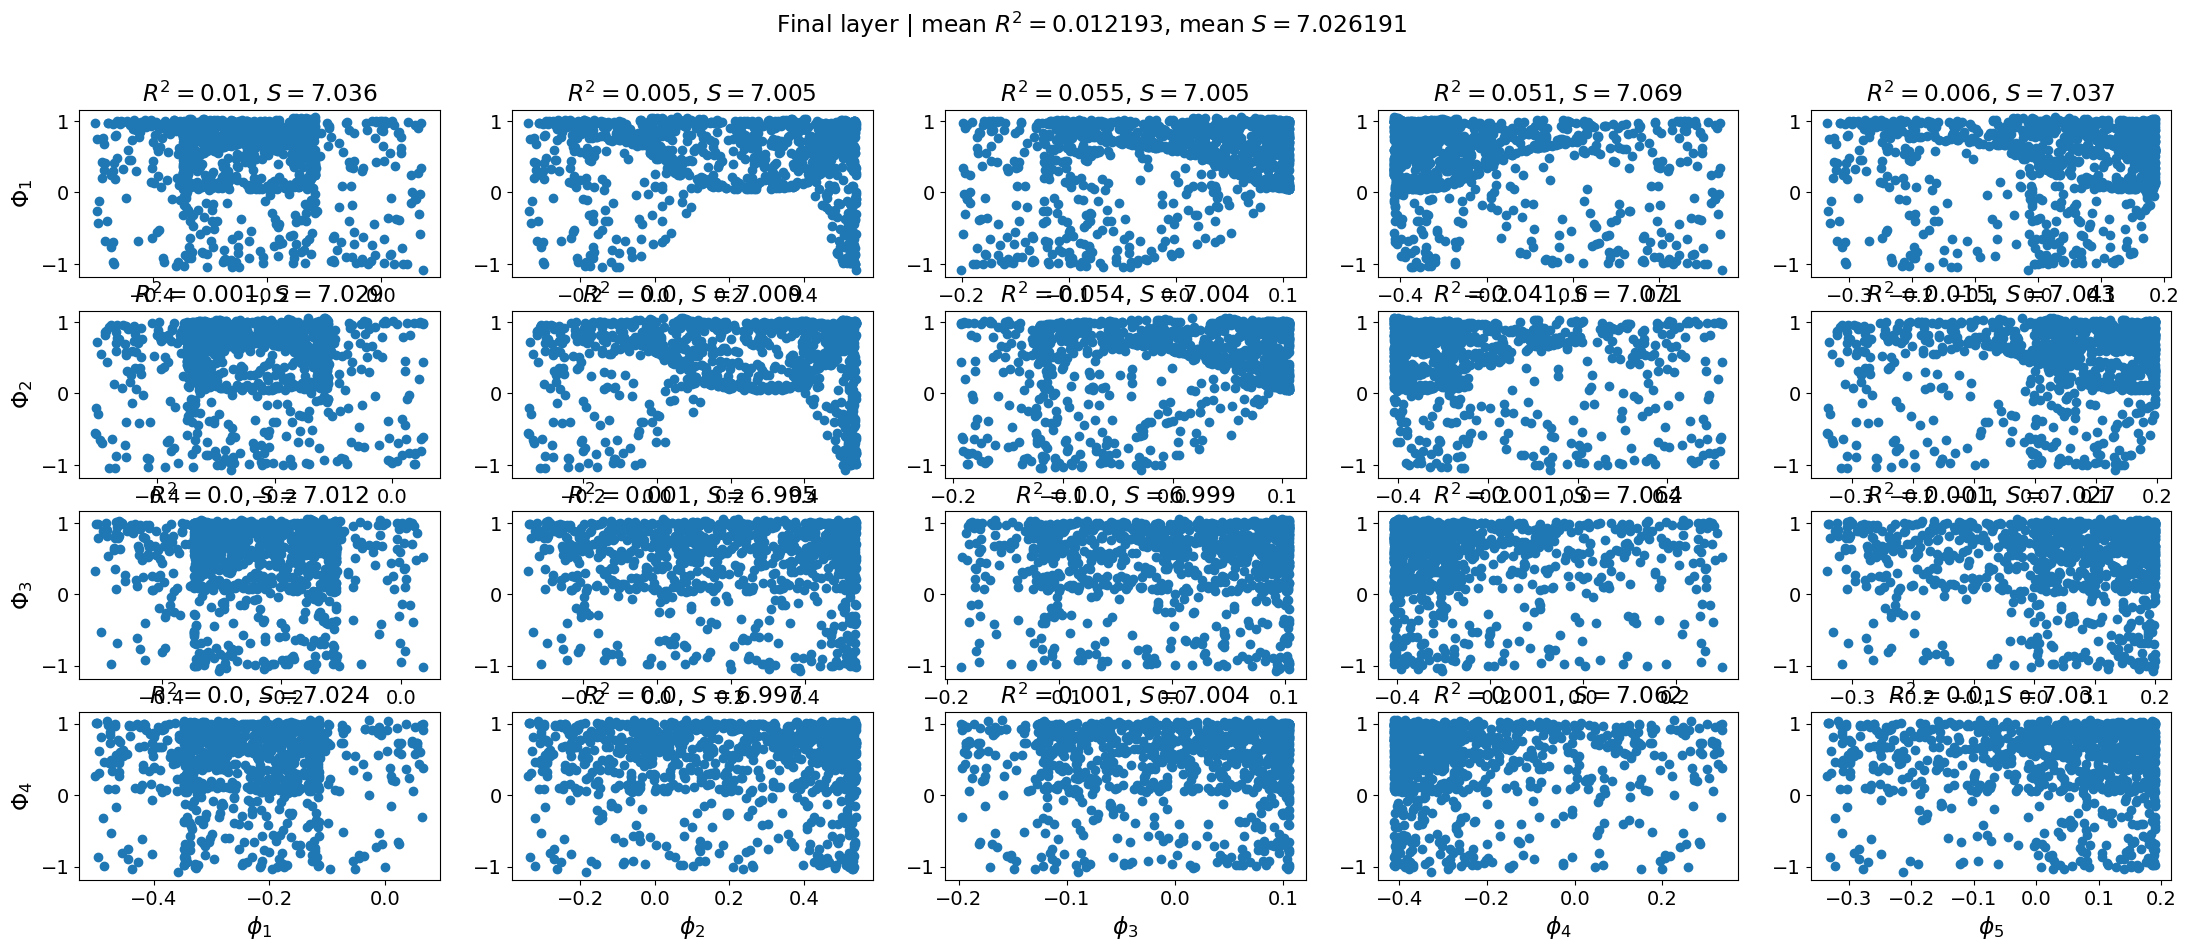

{'mean_r2': 0.0121926791466489, 'mean_matrix_entropy': 7.026190757751465}

In [8]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')


-----
-----
## $f_2(x_1, x_2, x_3, x_4)$

## $x_3, x_4$ - LC($x_3, x_4$) + normal random

##### $f_2(x_1, x_2, x_3, x_4) = \sin(\pi \cdot (x_1 \cdot x_2 + \tanh(x_1^2+x_2^2)))$

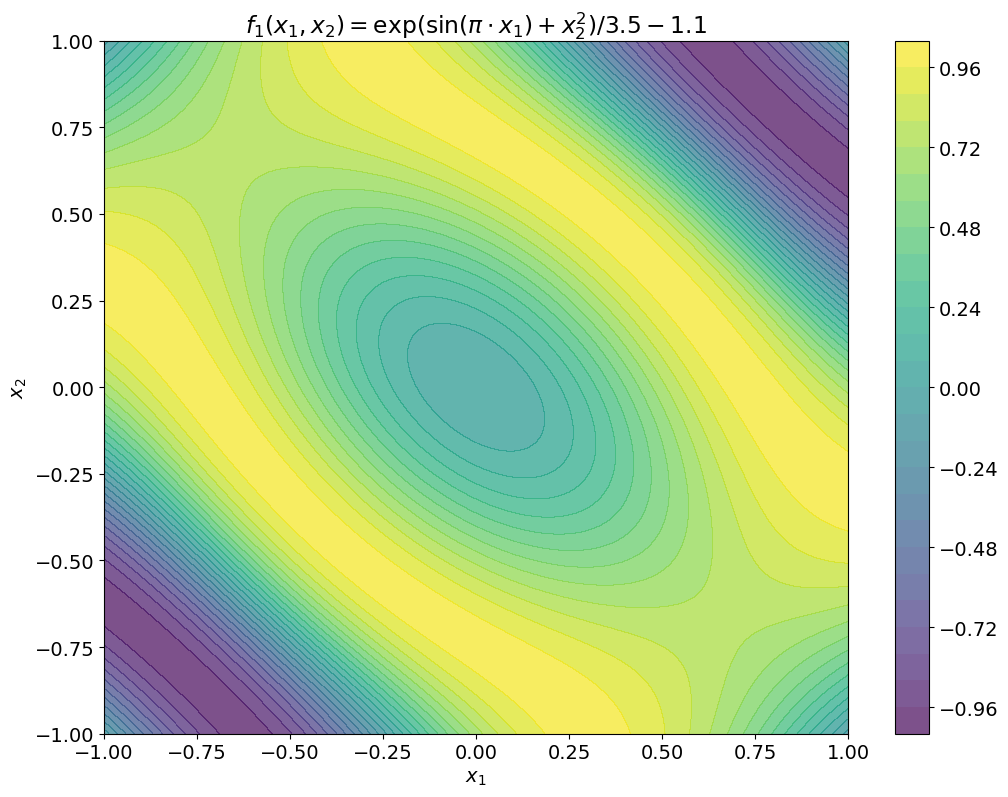

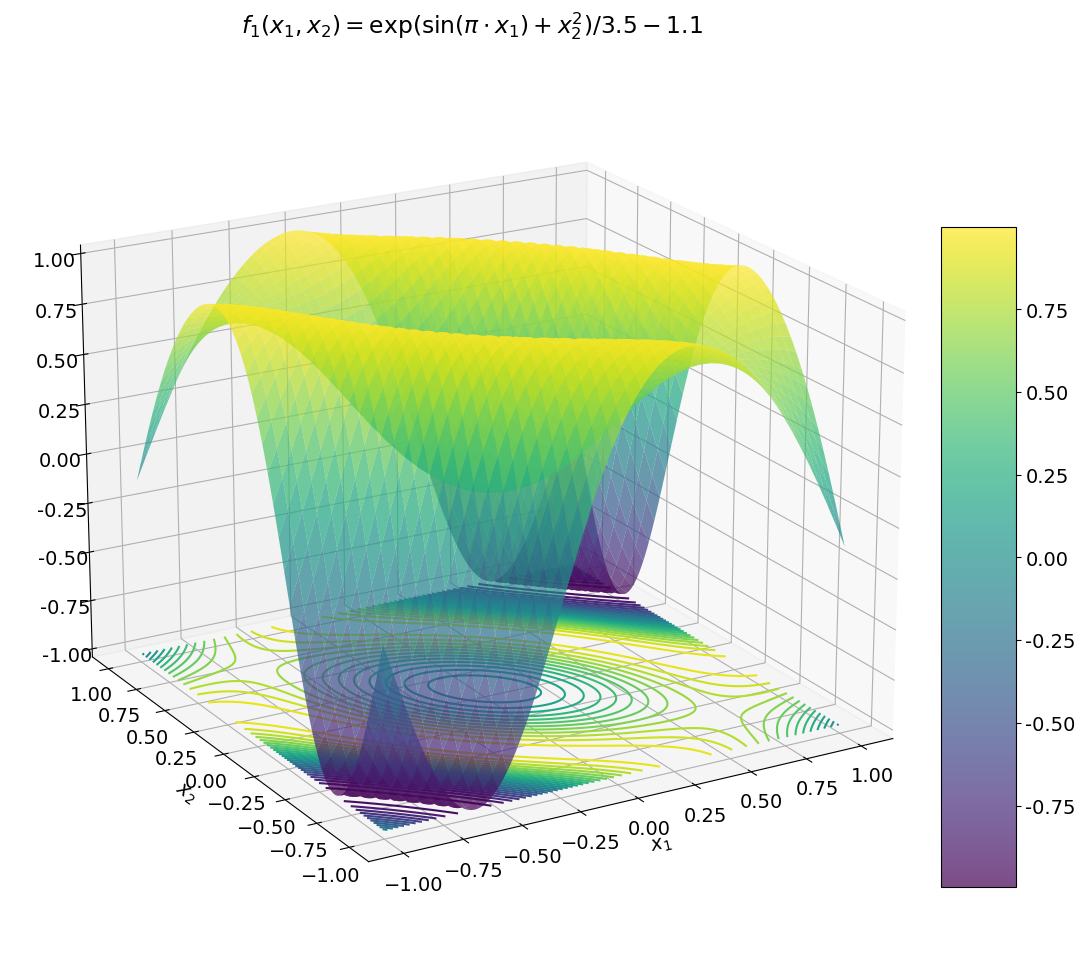

In [9]:
# create dataset
f2 = lambda x: torch.sin(torch.pi*( (x[:,[0]]*x[:,[1]]) + torch.tanh(x[:,[0]]**2 + x[:,[1]]**2) ))
dataset2 = create_dataset(f2, n_var=2, device=device)

# adding new inputs
SNR = 20 #noize_ampl=1 with SNR=20
noize_ampl = 10**(-SNR/20)

add_x = torch.stack((2**(-0.5)*dataset2['train_input'][:,0] + 2**(-0.5)*dataset2['train_input'][:,1] + noize_ampl*torch.randn(*dataset2['train_input'][:,0].shape),
                     2**(-0.5)*dataset2['train_input'][:,0] - 2**(-0.5)*dataset2['train_input'][:,1] + noize_ampl*torch.randn(*dataset2['train_input'][:,0].shape))
                     , dim=1)
dataset2['train_input'] = torch.concat((dataset2['train_input'], add_x), dim=1)

add_x = torch.stack((2**(-0.5)*dataset2['test_input'][:,0] + 2**(-0.5)*dataset2['test_input'][:,1] + noize_ampl*torch.randn(*dataset2['test_input'][:,0].shape),
                     2**(-0.5)*dataset2['test_input'][:,0] - 2**(-0.5)*dataset2['test_input'][:,1] + noize_ampl*torch.randn(*dataset2['test_input'][:,0].shape)), 
                    dim=1)
dataset2['test_input'] = torch.concat((dataset2['test_input'], add_x), dim=1)

f = f2
dataset = dataset2

plot_f_2d(f2, title='$f_1(x_1, x_2) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$')
plot_f_3d(f2, title='$f_1(x_1, x_2) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$')

-----
### MLP on $f_2$

№ model trainable params: 246


description:   0%|                                                          | 0/100 [00:00<?, ?it/s]

| train_loss: 2.14e-02 | test_loss: 2.13e-02 | reg: 1.21e+02 | : 100%|█| 100/100 [00:34<00:00,  2.88


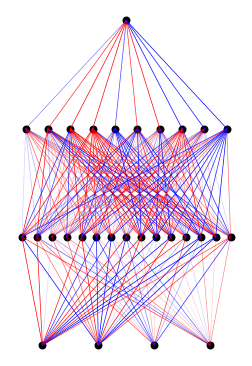

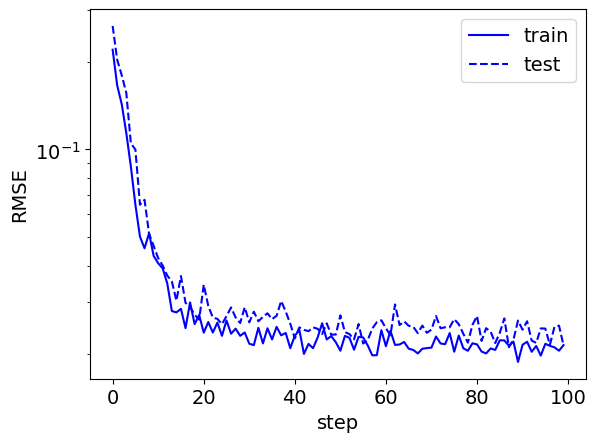

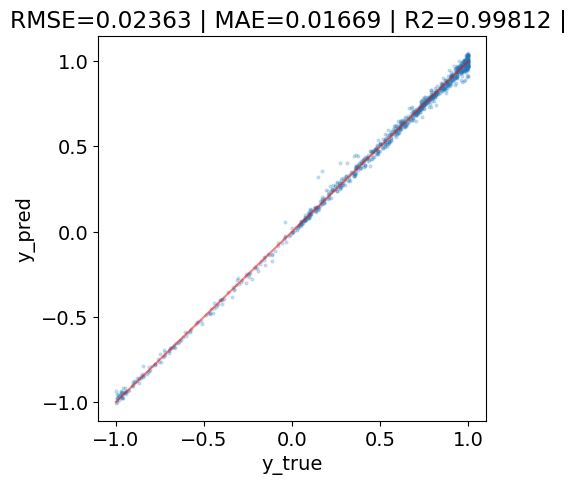

In [10]:
# initialize MLP
model = MLP(width=[4,15,10,1], seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb = 0, batch=250)
kan_summary_after_fit(model, dataset, results)

-----
### KAN on $f_2$

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 300


description:   0%|                                                          | 0/100 [00:00<?, ?it/s]

| train_loss: 4.41e-02 | test_loss: 5.37e-02 | reg: 1.62e+01 | : 100%|█| 100/100 [04:14<00:00,  2.54


saving model version 0.1


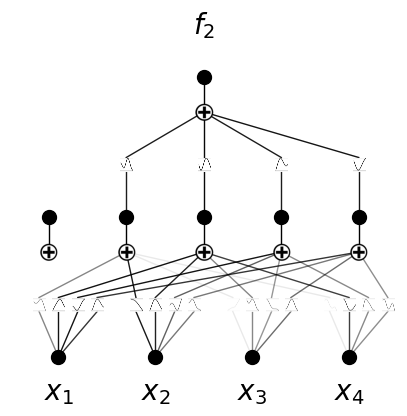

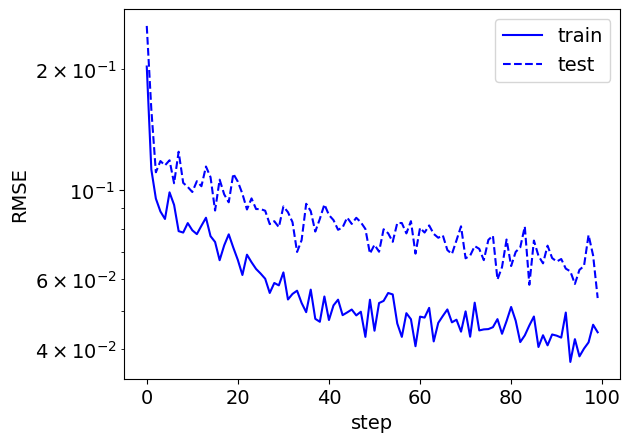

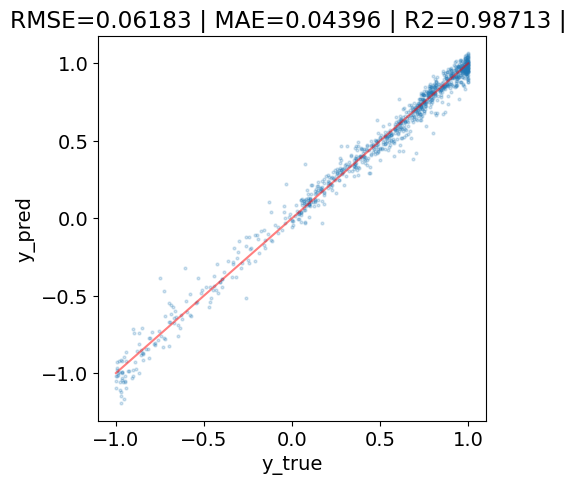

In [11]:
# initialize KAN with G=3
model = KAN(width=[4,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb=1e-4, update_grid=False, batch=250)
kan_summary_after_fit(model, dataset, results, in_vars = ['$x_1$', '$x_2$', '$x_3$', '$x_4$'], out_vars = ['$f_2$'])

-----
### $\lambda$-KAN on $f_2$

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 184


description:   0%|                                                          | 0/150 [00:00<?, ?it/s]

| train_loss: 3.52e-02 | test_loss: 4.01e-02 | reg: 2.29e+01 | : 100%|█| 150/150 [01:04<00:00,  2.32


saving model version 0.1


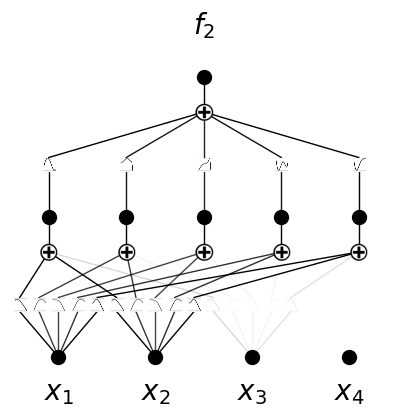

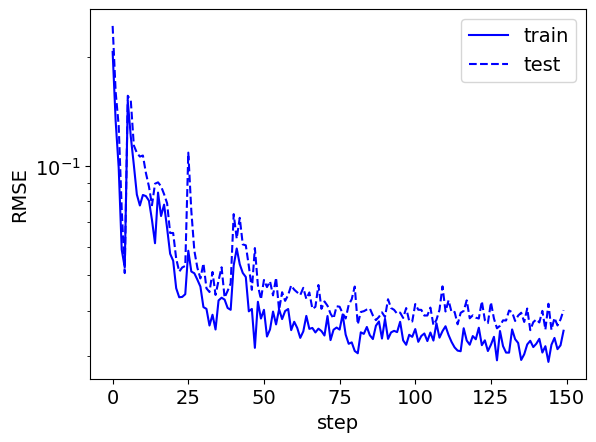

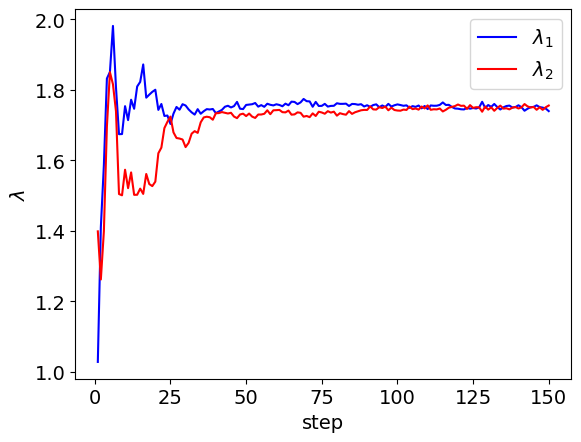

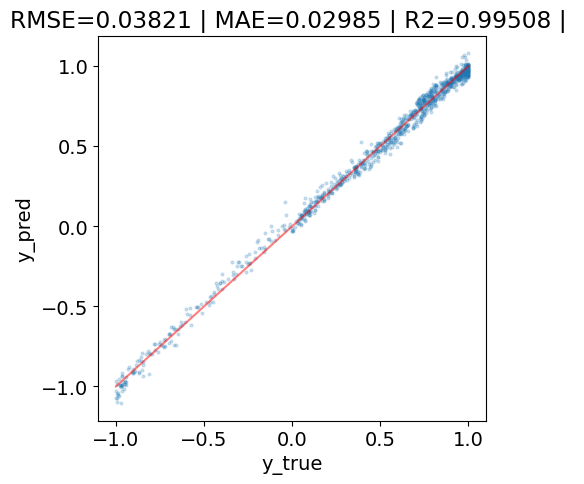

model.act_fun[0].lmd=Parameter containing:
tensor([ 1.7391e+00,  1.7550e+00,  8.2198e-02, -3.8679e-04],
       requires_grad=True)


In [13]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[4,5,1], grid=3, k=3, seed=2, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=0.0, reg_type='entropy',
                    batch=250)
kan_summary_after_fit(model, dataset, results, lmdKAN=True, in_vars = ['$x_1$', '$x_2$', '$x_3$', '$x_4$'], out_vars = ['$f_2$'])
print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [00:36, 18.48it/s]                         


module of Input importance:


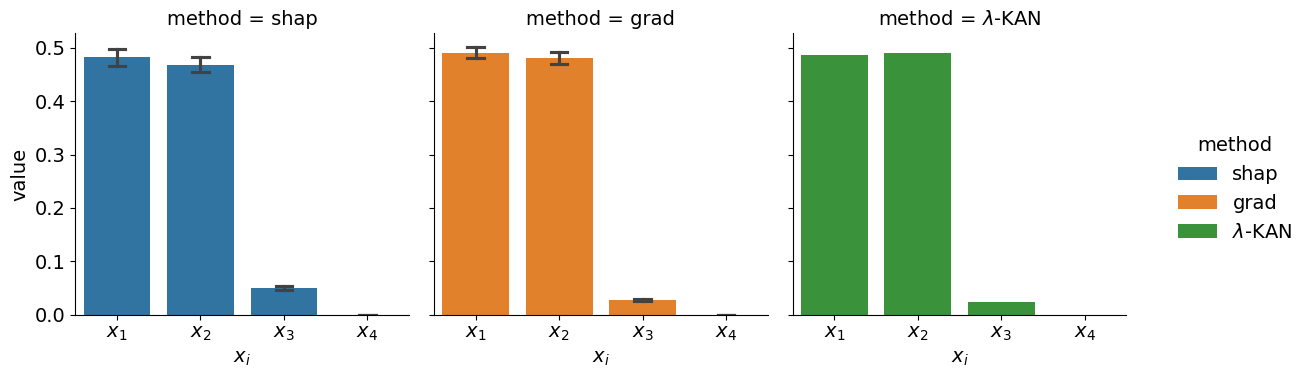

Input importance:


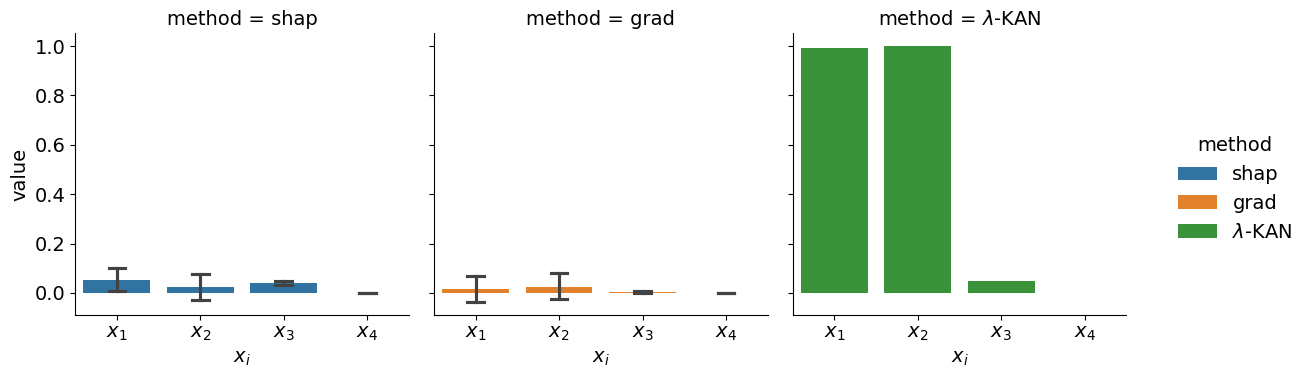

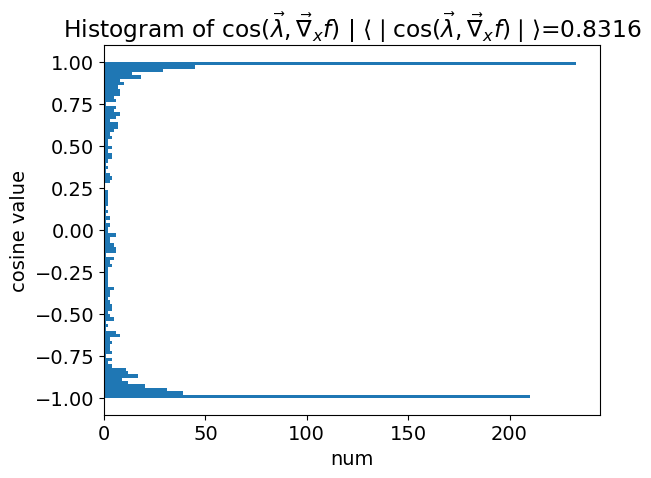

In [14]:
importance_analyse_lmdKAN(model, dataset)

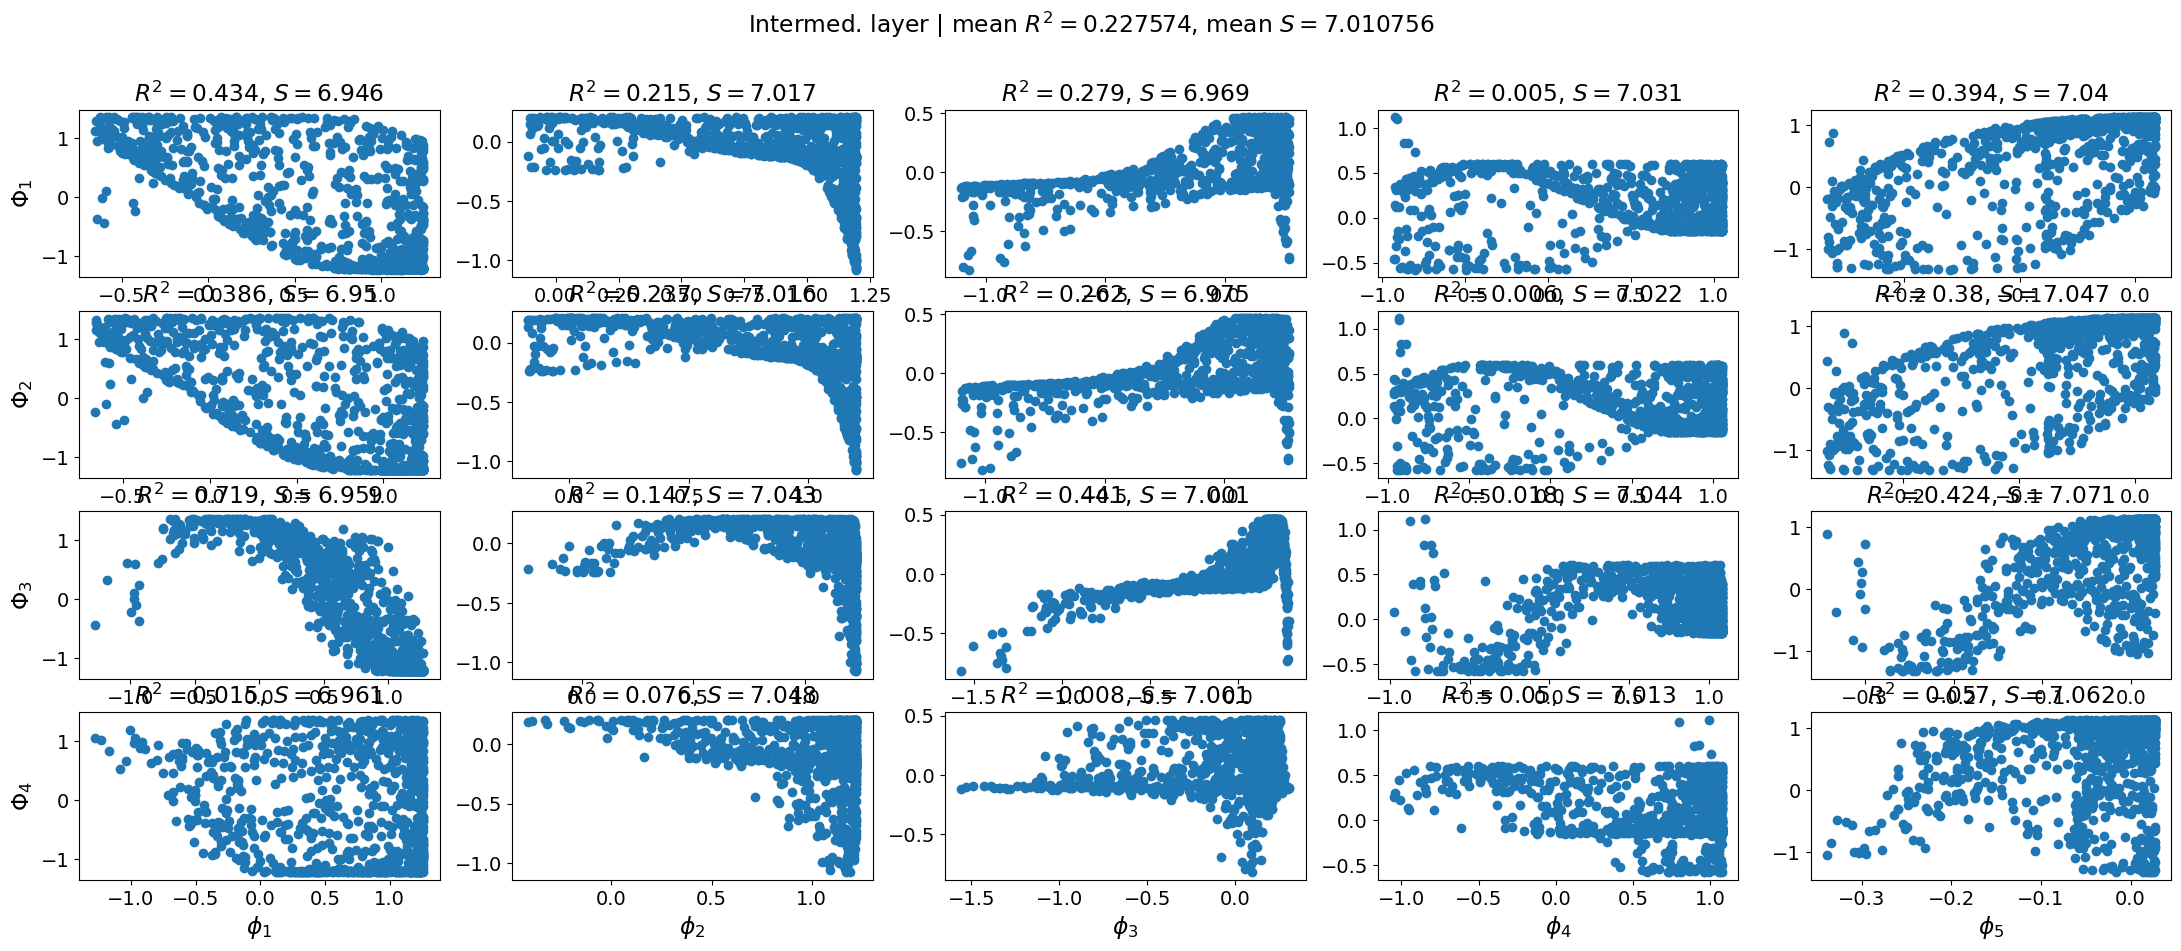

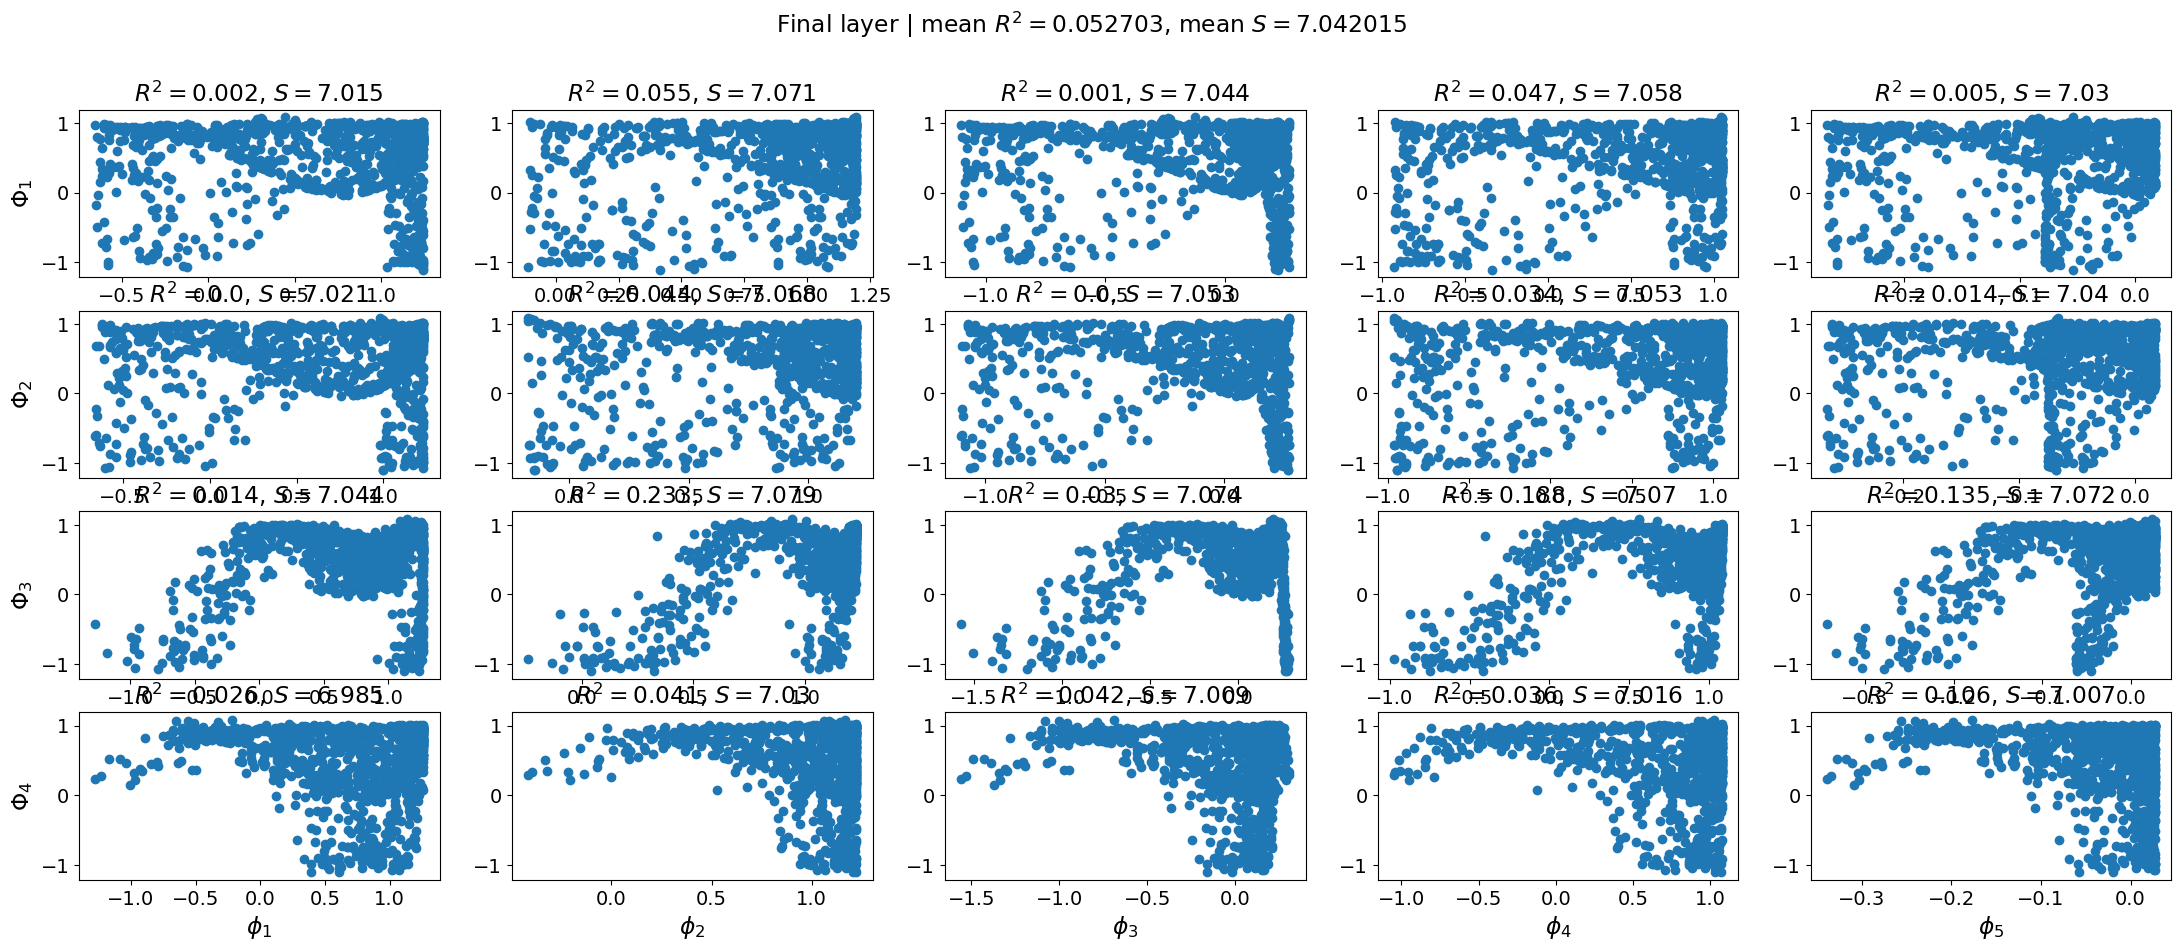

{'mean_r2': 0.05270348865451524, 'mean_matrix_entropy': 7.042015075683594}

In [15]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')